## Imports

In [1]:
import harp
import numpy as np
from pathlib import Path
import os
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import copy
from statistics import *

## Setup \

In [76]:
# base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/')
#base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/training_day5')
#base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824')
#base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_training_day5')
base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&open_190824')


In [26]:
def get_register_object(register_number, harp_board='h1'):
    
    h1_reader = harp.create_reader(f'h1-device.yml', epoch=harp.REFERENCE_EPOCH)
    h2_reader = harp.create_reader(f'h2-device.yml', epoch=harp.REFERENCE_EPOCH)
    reference_dict = {
        'h1': {
            32: h1_reader.Cam0Event,
            33: h1_reader.Cam1Event,
            38: h1_reader.StartAndStop,
            46: h1_reader.OpticalTrackingRead
        },
        'h2': {
            38: h2_reader.Encoder,
            39: h2_reader.AnalogInput,
            42: h2_reader.ImmediatePulses
        }
    }
    return reference_dict[harp_board][register_number]

## Automatic loading

In [37]:
def load_register_paths(dataset_path):
    
    if not os.path.exists(dataset_path/'HarpDataH1') or not os.path.exists(dataset_path/'HarpDataH2'):
        raise FileNotFoundError(f"'HarpDataH1' or 'HarpDataH2' folder was not found in {dataset_path}.")
    h1_folder = dataset_path/'HarpDataH1'
    h2_folder = dataset_path/'HarpDataH2'
    
    h1_files = os.listdir(h1_folder)
    h1_files = [f for f in h1_files if f.split('_')[0] == 'HarpDataH1']
    h1_dict = {int(filename.split('_')[1]):h1_folder/filename for filename in h1_files}
    
    h2_files = os.listdir(h2_folder)
    h2_files = [f for f in h2_files if f.split('_')[0] == 'HarpDataH2']
    h2_dict = {int(filename.split('_')[1]):h2_folder/filename for filename in h2_files}
    
    #print(f'Dataset {dataset_path.name} contains following registers:')
    #print(f'H1: {list(h1_dict.keys())}')
    #print(f'H2: {list(h2_dict.keys())}')
    
    return h1_dict, h2_dict

def load_registers(dataset_path):
    
    h1_dict, h2_dict = load_register_paths(dataset_path)
    
    h1_data_streams = {}
    for register in h1_dict.keys():
        data_stream = utils.load(get_register_object(register, 'h1'), dataset_path/'HarpDataH1')
        if data_stream.columns.shape[0] > 1:
            for col_name in data_stream.columns:
                h1_data_streams[f'{col_name}({register})'] = data_stream[col_name]
        elif data_stream.columns.shape[0] == 1:
            h1_data_streams[f'{data_stream.columns[0]}({register})'] = data_stream
        else:
            raise ValueError(f"Loaded data stream does not contain supported number of columns in Pandas DataFrame. Dataframe columns shape = {data_stream.columns.shape}")
            
    h2_data_streams = {}
    for register in h2_dict.keys():
        data_stream = utils.load(get_register_object(register, 'h2'), dataset_path/'HarpDataH2')
        if data_stream.columns.shape[0] > 1:
            for col_name in data_stream.columns:
                h2_data_streams[f'{col_name}({register})'] = data_stream[col_name]
        elif data_stream.columns.shape[0] == 1:
            h2_data_streams[f'{data_stream.columns[0]}({register})'] = data_stream[data_stream.columns[0]]
        else:
            raise ValueError(f"Loaded data stream does not contain supported number of columns in Pandas DataFrame. Dataframe columns shape = {data_stream.columns.shape}")
            
    return h1_data_streams, h2_data_streams

def plot_dataset(dataset_path):
    h1_data_streams, h2_data_streams = load_registers(dataset_path)
    for register, register_stream in h1_data_streams.items():
        plot_detail(register_stream, dataset_path.name, register=str(register))
    for register, register_stream in h2_data_streams.items():
        plot_detail(register_stream, dataset_path.name, register=str(register))

In [38]:
def get_run_treshold(mouse,treshold = 100, basepath = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/')):
    #optical_stream_df = utils.load(get_register_object(46, 'h1'), path/'HarpDataH1')
    print('\n Counts')
    #basepath = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/training_day5')
    path = basepath/mouse
    streams = load_registers(path)
    position_units = streams[0]['OpticalTrackingRead0X(46)'].to_numpy()
    #ignoring everything below 0
    position_units = position_units[position_units>=0]
    
    #plotting 
    fig, ax = plt.subplots(2)
    ax[0].plot(streams[0]['OpticalTrackingRead0X(46)'])
    ax[0].axhline(treshold)
    ax[1].hist(streams[0]['OpticalTrackingRead0X(46)'])
    fig.suptitle(mouse[-4:])
    
    #caclulating the running stats
    print('Count mean',mean(position_units))
    print('Count median', median(position_units))
    
    print(f'mean Count > {treshold}:',mean(position_units[position_units>=treshold]))
    print(f'median Count > {treshold}:', median(position_units[position_units>=treshold]))

    over_tresh = len(position_units[position_units>=treshold])
    #Porportion of time spent over treshold of the time moving or above 0
    print(over_tresh, len(position_units))
    time_spent_moving = over_tresh *100/len(position_units)
    
    print('\n Time spent above treshold', time_spent_moving)
    
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46)
    linear_velocity = meters_per_count / dt
    
    #Translating to cm/sec
    cm_treshold = treshold* linear_velocity * 100
    print('\n','treshold in cm ', cm_treshold)
    
  
    
    return position_units
    

In [77]:
# dataset_name = 'Main_harpsync_test/2024-06-05T15-04-41'
B3M3 = '2024-08-05T12-38-07_B3M3'
B3M1 = '2024-08-05T14-17-26_B3M1'
B3M2 = '2024-08-05T15-27-29_B3M2'
B2M5 = '2024-08-05T16-10-36_B2M5'
B2M4 = '2024-08-05T16-40-36_B2M4'


B3M3 ='2024-08-08T10-05-26_B3M3'
B3M1 = '2024-08-08T11-01-22_B3M1'
B3M2 = '2024-08-08T12-03-57_B3M2'
B2M5 = '2024-08-08T08-22-12_B2M5'
B2M4 = '2024-08-08T09-20-54_B2M4'
animal_list = [B3M3, B2M4, B2M5, B3M2, B3M1]

B2M6 = '2024-08-18T11-21-22_B2M6'
B3M8 = '2024-08-18T11-51-53_B3M8'
B3M7 = '2024-08-18T12-17-40_B3M7'
B3M6 = '2024-08-18T12-51-48_B3M6'
B3M4 = '2024-08-18T13-17-44_B3M4'
animal_list = [B2M6, B3M8, B3M7, B3M6, B3M4]

B2M6 = '2024-08-19T12-09-08_B2M6'
B3M8 = '2024-08-19T12-52-52_B3M8'
B3M7 = '2024-08-19T13-34-41_B3M7'
B3M6 = '2024-08-19T14-18-09_B3M6'
B3M4 = '2024-08-19T14-58-24_B3M4'
animal_list = [B2M6, B3M8, B3M7, B3M6, B3M4]

Mouse:  B2M6

 Counts
Count mean 44
Count median 1.0
mean Count > 100: 182
median Count > 100: 173.0
31308 158400

 Time spent above treshold 19.765151515151516

 treshold in cm  2.1166666666666663

Mouse:  B3M8

 Counts
Count mean 123
Count median 115
mean Count > 100: 210
median Count > 100: 204.0
94444 174663

 Time spent above treshold 54.072127468324716

 treshold in cm  2.1166666666666663

Mouse:  B3M7

 Counts
Count mean 347
Count median 363.0
mean Count > 100: 369
median Count > 100: 373
174795 187014

 Time spent above treshold 93.46626455773365

 treshold in cm  2.1166666666666663

Mouse:  B3M6

 Counts
Count mean 130
Count median 102.0
mean Count > 100: 242
median Count > 100: 231
79207 157350

 Time spent above treshold 50.33809977756594

 treshold in cm  2.1166666666666663

Mouse:  B3M4

 Counts
Count mean 117
Count median 71
mean Count > 100: 238
median Count > 100: 226
70069 156269

 Time spent above treshold 44.83870761315424

 treshold in cm  2.1166666666666663



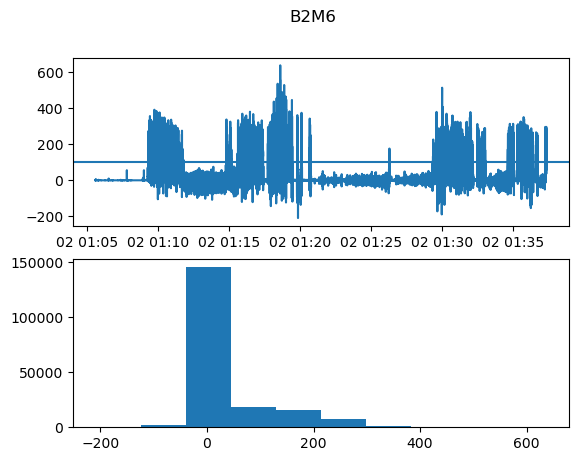

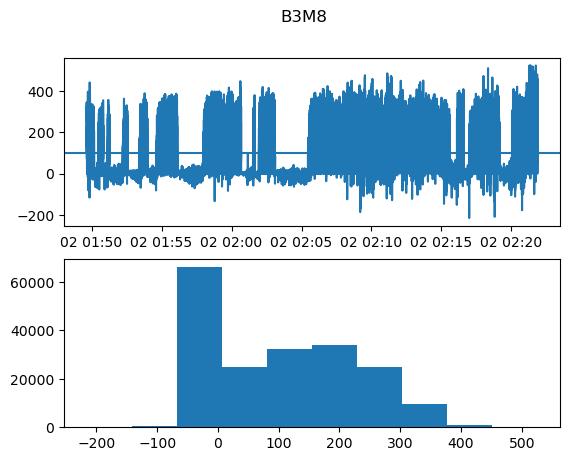

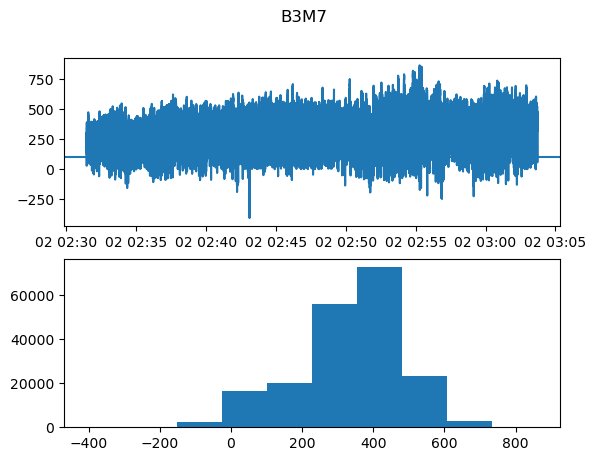

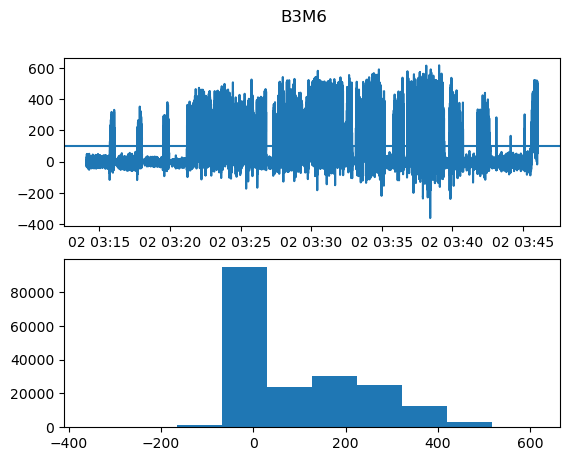

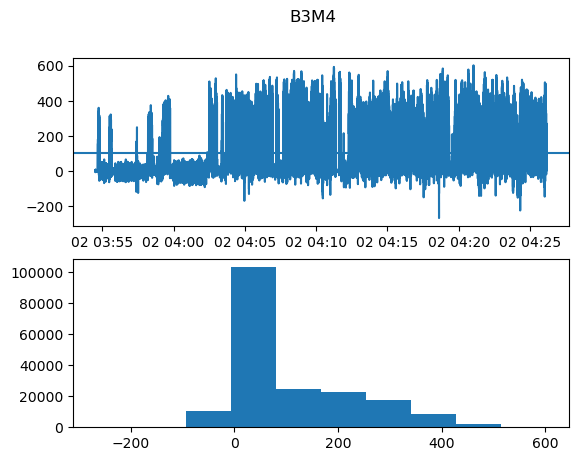

In [78]:
#fig, axs = plt.subplots(len(animal_list))
#axlist = []
animal_data = {}
for animal in animal_list:
    print('Mouse: ', animal[-4:])
    animal_data[f'{animal[-4:]}']=get_run_treshold(animal, treshold=100, basepath = base_path)
    print('')
    #axlist.append(get_run_treshold(animal))

(86000.0, 90000.0)

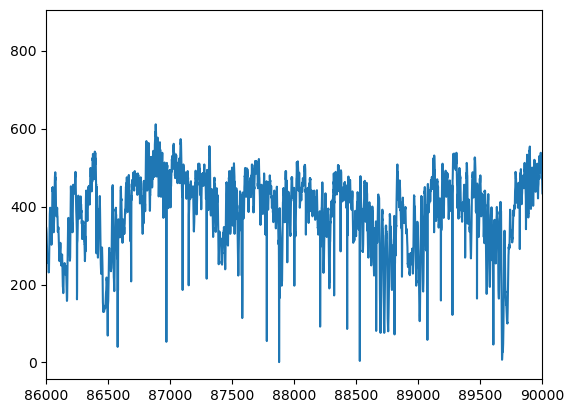

In [123]:
plt.plot(animal_data['B3M7'])
plt.xlim([86000,90000])


 Counts
Count mean 347
Count median 363.0
mean Count > 440: 506
median Count > 440: 488.0
47226 187014

 Time spent above treshold 25.252654881452724

 treshold in cm  9.313333333333333


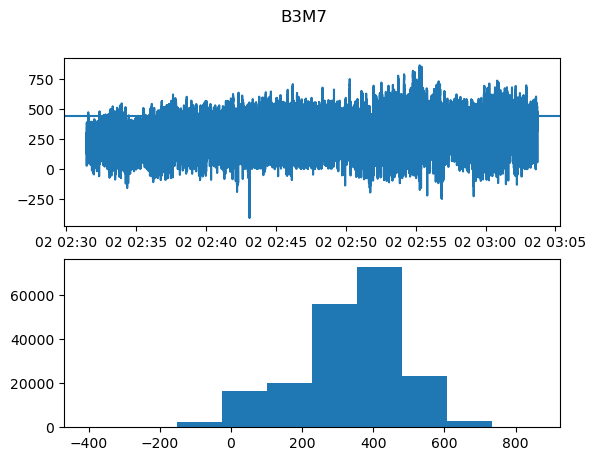

In [117]:
running = get_run_treshold(B3M7, treshold=440, basepath = base_path)


In [ ]:
print(running)